# Куда двигаться по этапам

Этап 0 — “пальчик”/захват на 1–2 степенях свободы (2–3 недели)
- Цель: научиться читать датчик и плавно двигать привод (серво/мотор), настроить питание и безопасность.

- Привод: умные сервы Dynamixel XL-320/AX-12A (есть позиция и «нагрузка») или обычные MG90S/DS3218 для старта.

- МК: Arduino Uno/Nano (очень просто) или Teensy 4.0/4.1 (реальное время, запас по мощи).

- Датчик: потенциометр (как тренажёр) → затем EMG MyoWare 2.0 (мио-сигнал с предплечья).

- Питание: LiPo 2S–3S + BMS или блок 6–12 В, step-down до 5–7.4 В для серв.

Безопасность: e-stop (кнопка обесточки), предохранитель, механические ограничители хода.

Этап 1 — кисть с тягами (месяц)
- Цель: собрать 3–5 «сухожилий» (Bowden/леска) на сервомашинках, получить базовые жесты (сжать/разжать, “щипок”).

- Каркас: печать PLA/PETG (потом — нейлон/карбон).

- Обратная связь: энкодеры серв, тензодатчики в кончиках пальцев/ладони (давление/касание).

- Логика: конечный автомат, PID, простые профили скорости/ускорения.

Этап 2 — переход к «медицинскому» классу (дальше)

- Тихие приводы (линейные, безлюфтовые редукторы, BLDC + энкодер через ODrive/FOC).

- Надёжное питание, герметизация, кабель-менеджмент.

- Сигналы: стабильный EMG (экран, диффусъём), IMU в кисти, датчики силы в пальцах.

Стек: ROS 2 (rclpy/rclcpp) на Raspberry Pi + низкоуровневый МК по UART/CAN/TTL.

# Минимальный набор на «вчера» (чтобы уже поиграться)

- Arduino Nano/Uno

- Серво DS3218 (или Dynamixel XL-320, если хочешь «умные»)

- Потенциометр 10 kΩ + EMG MyoWare 2.0 (вторым шагом)

- Блок питания 6–7.4 В 3–5 А + понижайка на 5 В для логики

- Кнопка e-stop, предохранитель 5–10 А, провод 16–20 AWG

- Печатный «пальчик»/захват (любой простой STL из сети) + леска/тягa

# Первый эксперимент (1–2 часа)

Идея: поворачиваешь потенциометр — серво плавно сжимает «пальчик». Потом заменишь потенциометр на EMG.

In [ ]:
// Arduino — плавное управление сервой от датчика
#include <Servo.h>
Servo s;
const int pinServo = 9;
const int pinIn = A0;   // сначала потенциометр, позже EMG выход
int angle = 0;

void setup() {
  s.attach(pinServo);
}

void loop() {
  int raw = analogRead(pinIn);        // 0..1023
  // Небольшой мёртвый диапазон и сглаживание
  static float filt = 0;
  filt = 0.9f * filt + 0.1f * raw;    // простое EMA
  int mapped = map((int)filt, 100, 900, 0, 180); // подстрой границы под свой датчик
  mapped = constrain(mapped, 0, 180);

  // Плавная подводка к цели
  if (angle < mapped) angle++;
  else if (angle > mapped) angle--;

  s.write(angle);
  delay(10);
}


# Подключение:

- Серво: + к 6–7.4 В, GND общий с Arduino, сигнал → D9.

- Потенциометр: крайние выводы к 5 В и GND, средний → A0.

- EMG (позже): OUT → A0, ОБЯЗАТЕЛЬНО общий GND, электрод/экран по инструкции к модулю.

# Про датчики и управление

- EMG (мио): бери модули с гальванической развязкой/безопасной схемой, одноразовые электроды, экранированный кабель, прокладывай вне силовой части. Сначала учись на потенциометре — меньше шума/разочарований.

- Касание/сила: тензодатчики (FSR) под подушечки пальцев, или мини-якорные тензомосты в тягах — это даст рефлексы «не сжимай слишком сильно».

- Приводы: умные сервы (Dynamixel) = быстро стартануть: позиция, скорость, «нагрузка», шина. Дальше — BLDC + энкодер (тихо/мощно) через ODrive/FOC, но это сложнее.

# Минимальная архитектура

- MCU слой (Arduino/Teensy): опрос датчиков (EMG/FSR/IMU), локальные контуры PID, аварии (e-stop).

- SBC слой (Raspberry Pi): высокоуровневые жесты/режимы, обучение/классификация EMG (позже), интерфейс.

- Шины: UART/RS-485/TTL (Dynamixel), CAN (дальше), надёжное питание, развязки.

# Безопасность (обязательно)

- Гальваническая развязка или сертифицированные EMG-модули.

- Кнопка аварийной остановки, предохранители, токовые лимиты в драйверах.

- Механические упоры, чтобы не травмировать кожу/ткани.

- Если пойдёшь в сторону медицинского устройства: ориентируйся на IEC 60601, ISO 13485, EU MDR — это про электробезопасность, управление качеством и регистрацию (упростит путь к реальному применению).

# 30-дневный план (реалистичный)

Неделя 1: питание, серво, потенциометр → плавный захват, e-stop.
Неделя 2: ставишь EMG, добиваешься стабильного распознавания «напряг/расслаб».
Неделя 3: печатаешь 3-пальцевой захват с тягами, добавляешь FSR в кончики.
Неделя 4: профили движения (ускорение/торможение), простой «анти-слип»: если FSR растёт слишком быстро — снижать прижим.

# Наброски

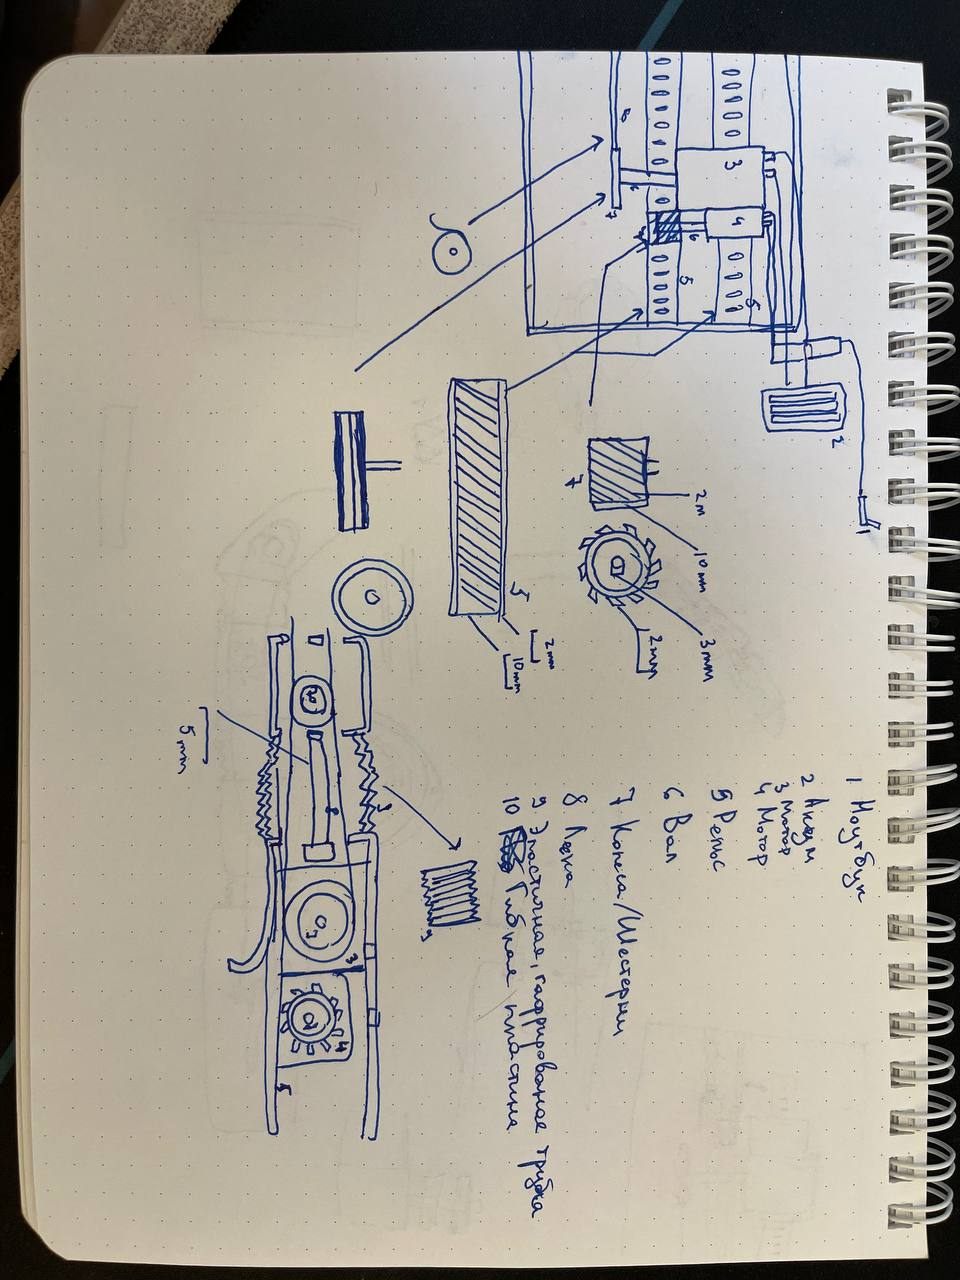